### Title

In [247]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import patsy
import statsmodels.api as sm
import warnings
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
from statsmodels.formula.api import ols

from collections import defaultdict
df = pd.read_excel('../data/tech_layoffs.xlsx')

df = df.drop(columns=['Company'])
df['Funding'] = df['Money_Raised_in_$_mil'].apply(lambda s: np.float64(s[1:])) 
df['Money_Raised_in_$_mil'] = df['Money_Raised_in_$_mil'].apply(lambda s: np.float64(s[1:])) 
df["Date_layoffs"] = df['Date_layoffs'].apply(lambda i: pd.to_datetime(str(i).split()[0], format="%Y-%d-%m") if i >= pd.to_datetime("2024-01-01", format="%Y-%d-%m") else i)

def getQuarter(i):
    return (int(str(i).split()[0].split("-")[1])+2) // 3

def getMonth(i):
    return int(str(i).split()[0].split("-")[1])

def getDay(i):
    return int(str(i).split()[0].split("-")[2])


df["Day"] = df["Date_layoffs"].apply(getDay)
df["Quarter"] = df["Date_layoffs"].apply(getQuarter)
df["Month"] = df["Date_layoffs"].apply(getMonth)

Some text explaining:
 - Which variable specifically we are looking into
 - It's relationship to the hypothesis
 - What we expect to find

We are going to do a time series analysis of our data. We aim to look at the correlation between time and the number of layoffs, specifically layoffs over the general period and trends based upon the month of the year. To do this, the data for our layoffs is first cleaned and then put into a seasonal decomposition with month-long buckets. From this, we can view the overall trend over the time period and the effect the month has on the number of layoffs.

In [239]:
# TODO: (OPTIONAL) Exploratory plot 2
# convert datetime

time_series_df = df[["Laid_Off", "Company_Size_before_Layoffs", "Company_Size_after_layoffs", "Date_layoffs", "Percentage"]]
time_series_df['Date_layoffs'] = pd.to_datetime(time_series_df['Date_layoffs'])

# aggregate dates if duplicate, sum
time_series_df = time_series_df.groupby("Date_layoffs").agg(["count", "sum"])

time_series_df.columns = time_series_df.columns.to_flat_index()#df.groupby("Date_layoffs")["Laid_Off"].mean()
time_series_df.columns = ["_".join(i) for i in time_series_df.columns]

# mean col
# put 0 values in place of NaN
time_series_df = time_series_df.resample('MS').sum()

time_series_df["Laid_Off_mean"] = time_series_df["Laid_Off_sum"]/time_series_df["Laid_Off_count"]
time_series_df["Percentage_mean"] = time_series_df["Percentage_sum"]/time_series_df["Percentage_count"]
#time_series_df

time_series_df = time_series_df.resample('MS').sum()
time_series_df

C:\Users\Steam\AppData\Local\Temp\ipykernel_20104\3043976946.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_series_df['Date_layoffs'] = pd.to_datetime(time_series_df['Date_layoffs'])


,Laid_Off_count,Laid_Off_sum,Company_Size_before_Layoffs_count,Company_Size_before_Layoffs_sum,Company_Size_after_layoffs_count,Company_Size_after_layoffs_sum,Percentage_count,Percentage_sum,Laid_Off_mean,Percentage_mean
Date_layoffs,,,,,,,,,,
2020-03-01,61,7441,61,25301,61,17860,61,2269.666667,121.983607,37.207650
2020-04-01,151,21864,151,112909,151,91045,151,3377.241077,144.794702,22.365835
2020-05-01,65,21404,65,122644,65,101240,65,1706.000000,329.292308,26.246154
2020-06-01,29,6442,29,58281,29,51839,29,660.000000,222.137931,22.758621
2020-07-01,10,2198,10,28502,10,26304,10,300.000000,219.800000,30.000000
2020-08-01,7,1853,7,55075,7,53222,7,305.000000,264.714286,43.571429
2020-09-01,4,339,4,1836,4,1497,4,117.000000,84.750000,29.250000
2020-10-01,2,110,2,779,2,669,2,25.000000,55.000000,12.500000
2020-11-01,3,189,3,234,3,45,3,175.000000,63.000000,58.333333


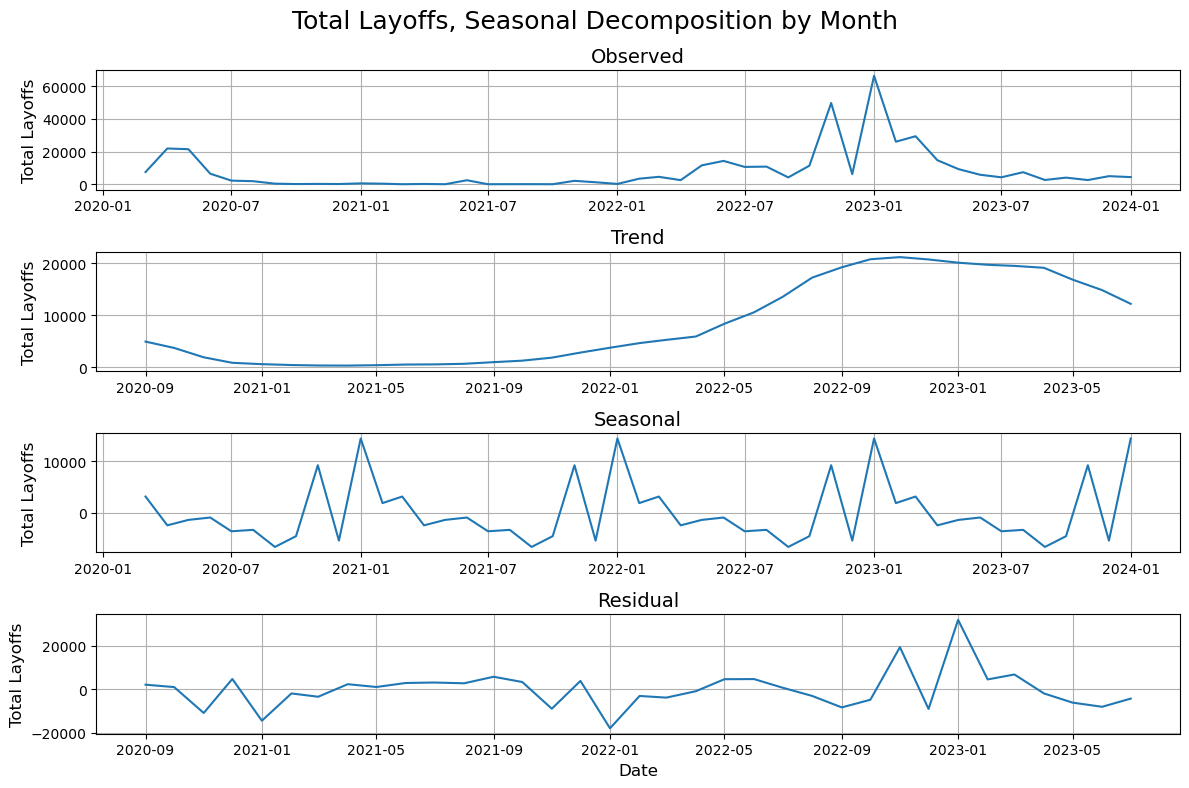

In [242]:

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(time_series_df['Laid_Off_sum'], model='additive', period=12)
#result.plot()
#time_series_df

### begin plots ###
plt.figure(figsize=(12, 8))

plt.suptitle("Total Layoffs, Seasonal Decomposition by Month", fontsize = 18)

# observed
plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.title('Observed', fontsize=14)
plt.ylabel('Total Layoffs', fontsize=12)
plt.grid(True)

# trend
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.title('Trend', fontsize=14)
plt.ylabel('Total Layoffs', fontsize=12)
plt.grid(True)

# seasonal
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.title('Seasonal', fontsize=14)
plt.ylabel('Total Layoffs', fontsize=12)
plt.grid(True)

# residual
plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.title('Residual', fontsize=14)
plt.ylabel('Total Layoffs', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()
#time_series_df

As a result of the seasonal decomposition we have the data decomposed into three components. We can think of each graph like this: `observed = trend + seasonal + residual`. The "trend" component will show a sort of smoothed idea of how the data changes over time. The "seasonal" component is cyclic and yearly -- it looks to describe purely the effect that each month will have on the total layoffs. The "residual" component shows unexpected and unexplained things in the data.

The trend line illustrates a significant increase in layoffs between late 2022 to early 2023, where it then begins to slowly decrease in mid 2023. The seasonal line shows an annual pattern, suggesting a seasonal effect on layoffs. It shows increases in layoffs during certain months of the year, namely November and January. The largest peak layoffs in January could possibly be attributed to the fact that the previous corporate fiscal year has just ended; companies who have performed poorly may decide to downsize. The residual plot, which is typically used for identifying anomalies and irregularities in data, peaks at late 2022 and the start of 2023, indicating a possible unexpected or anomalous event that caused layoff rates to deviate from their typical trends.

As a disclaimer, there are certain months with no layoffs recorded whatsoever in this dataset that occur in 2021. In fact, 2021 has the fewest number of layoff events recorded overall (less than 20 individual layoff events) and as a result we cannot be confident drawing any conclusions for this year in particular.

Set up Null hypothesis and Alternative hypothesis
 - Null: Time of the year does not affect the number of layoffs.
 - Alternative: Time of the year affects the number of layoffs.

$ H_0: \mu_{\text{purebred}} = \mu_{\text{mixed-breed}} $

$ H_1: \mu_{\text{purebred}} < \mu_{\text{mixed-breed}} $

note: smaller adoption speed means faster

In [248]:
df.head()

,#,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng,Funding,Day,Quarter,Month
0,3,Bengaluru,India,Asia,200,2023-12-20,15.0,1333,1133,Consumer,Series H,1700.0,2023,12.97194,77.59369,1700.0,20,4,12
1,4,Haifa,Israel,Asia,100,2023-12-19,20.0,500,400,Healthcare,Unknown,733.0,2023,32.81841,34.98850,733.0,19,4,12
2,6,San Francisco Bay Area,USA,North America,350,2023-12-18,10.0,3500,3150,Energy,Post-IPO,116.0,2023,37.54827,-121.98857,116.0,18,4,12
3,7,Bengaluru,India,Asia,100,2023-12-18,10.0,1000,900,Retail,Unknown,500.0,2023,12.97194,77.59369,500.0,18,4,12
4,14,San Francisco Bay Area,USA,North America,900,2023-12-14,24.0,3750,2850,Transportation,Acquired,15000.0,2023,37.77493,-122.41942,15000.0,14,4,12


In [249]:
# TODO: Perform 1 stats test (don't print entire output of a model, only the p-value)
# regression analysis 
X = df[["Year", "Month", "Quarter", "Day"]]
X = sm.add_constant(X) 
y = df['Laid_Off']

# regression model
model = sm.OLS(y, X).fit()
model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:               Laid_Off   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.170
Date:                Tue, 19 Mar 2024   Prob (F-statistic):             0.0132
Time:                        16:13:56   Log-Likelihood:                -11615.
No. Observations:                1418   AIC:                         2.324e+04
Df Residuals:                    1413   BIC:                         2.327e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.103e+05    4.1e+04     -2.691      0.0

From our linear regression above, we can see that there is a statistically significant effect that the "Year" has on the number of employees laid off. Meanwhile, there are statistically insignificant effects from "Month", "Quarter", and "Day", suggesting that the overall time period is what affects the number of employees laid off as opposed to the cyclical periods within the year. 